In [1]:
# !apt-get update && apt-get install libsm6 libxext6 -y -qq
# !apt-get install libgl1-mesa-glx graphviz -y -qq
# !pip install -r requirements.txt
# import os
# os._exit(0)
# # # !apt-get install unrar

# IMPORT PACKAGES

In [3]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys
import math
import random
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2.15.0
time: 850 µs (started: 2024-12-05 15:03:37 +00:00)


In [4]:
EPOCHS = 2000
BATCH = 4
ETA = 1e-3
WEIGHT_DECAY = 6e-8
IMAGE_SHAPE = (512, 1024, 1)
MASK_SHAPE = (512, 1024, 1)
model_path = './models'
plot_path = './chart'

time: 306 µs (started: 2024-12-05 15:03:37 +00:00)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Enable GPU memory growth (optional)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    # Set mixed precision policy
    # policy = tf.keras.mixed_precision.Policy('mixed_float16')
    # tf.keras.mixed_precision.set_global_policy(policy)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow GPU device: ", tf.test.gpu_device_name())
print("All devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
TensorFlow GPU device:  /device:GPU:0
All devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 1.06 s (started: 2024-12-05 15:03:37 +00:00)


2024-12-05 15:03:37.827513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 15:03:37.851367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 15:03:37.851536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# READ DATASET (IMAGES, MASKS)

In [6]:
#custom augmentation that simulate random light appears in vertical block of ct-scan results
class VerticalBrightnessBlock(A.ImageOnlyTransform):
    def __init__(self, block_width=(10, 50), intensity=(200, 255), always_apply=False, p=0.5):
        super(VerticalBrightnessBlock, self).__init__(always_apply=always_apply, p=p)
        self.block_width = block_width
        self.intensity = intensity

    def apply(self, img, **params):
        img = img.copy()
        h, w = img.shape[:2]
        # Random block width
        block_w = random.randint(self.block_width[0], self.block_width[1])
        # Random block position
        start_x = random.randint(0, w - block_w)
        # Random brightness intensity
        intensity_value = random.randint(self.intensity[0], self.intensity[1])
        # Add the vertical block
        img[:, start_x:start_x + block_w] = np.clip(img[:, start_x:start_x + block_w] + intensity_value, 0, 255)
        return img

time: 693 µs (started: 2024-12-05 15:03:38 +00:00)


In [7]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
        self.images = None
        self.masks = None
        self.val_images = None
        self.val_masks = None
        self.test_images = None
        self.test_masks = None

    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
        try:
            shutil.rmtree(os.path.join(self.imagesPathes, ".ipynb_checkpoints"))
            shutil.rmtree(os.path.join(self.masksPathes, ".ipynb_checkpoints"))
            print(f".ipynb_checkpoints directory deleted successfully.")
        except Exception as e:
            print(f"just checking .ipynb_checkpoints (nothing)")

    def readImages(self, data, typeData):
        images = []
        height = 512
        width =  1024
        for img in data:
            img_name = img.name
            img = cv2.imread(str(img), 0)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
        print("(INFO..) Read Image Done")
        return np.array(images)

    def normalizeImages(self, images):
        normalized_images = []
        clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
        for img in images:
            img = img.astype(np.uint8)
            img = clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = img / 255.
            normalized_images.append(img)
        print("(INFO..) Normalization Image Done")
        return np.array(normalized_images)

    def dataAugmentation(self, images, masks):
        augmentation = A.ReplayCompose([
            A.HorizontalFlip(p=0.5),
            # Vertical Translation
            A.ShiftScaleRotate(
                shift_limit_x=(-0.05, 0.05),
                shift_limit_y=(-0.1, 0.05),
                scale_limit=(-0.05, 0.05), 
                rotate_limit=0,
                interpolation=cv2.INTER_AREA,
                mask_interpolation=cv2.INTER_AREA,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5,
            ),
            A.RandomGamma(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.25, 0.4),
                                       contrast_limit=(-0.25, 0.35),
                                       p=0.5),
            A.ElasticTransform(alpha=10, 
                               sigma=10, 
                               interpolation=cv2.INTER_AREA,
                               mask_interpolation=cv2.INTER_AREA,
                               p=0.2)
        ], bbox_params=None)
        
        if len(images) != len(masks):
            raise ValueError("Number of images and masks must be the same.")

        augmented_images = []
        augmented_masks = []

        for image, mask in zip(images, masks):
            # Original image and mask
            augmented_images.append(image)
            augmented_masks.append(mask)
            
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)
            
            # Perform augmentations
            # Generate 6 augmented versions per image
            for _ in range(4):                
                # Handle single-channel images
                if len(image.shape) == 2:
                    image = np.expand_dims(image, axis=-1)
                if len(mask.shape) == 2:
                    mask = np.expand_dims(mask, axis=-1)

                # Apply augmentation
                augmented = augmentation(image=image, mask=mask)
                
                augmented_images.append(augmented['image'])
                augmented_masks.append(augmented['mask'])
                
        print("(INFO..) Augmentation Image Done")
        return np.array(augmented_images), np.array(augmented_masks)
        
    
    def splitDataset(self, images, masks, val_size=20, test_size=10, random_state=42):
        data = list(zip(images, masks))
        train_data, test_data = train_test_split(data, test_size=(val_size + test_size), random_state=random_state)
        val_data, test_data = train_test_split(test_data, test_size=(test_size / (val_size + test_size)), random_state=random_state)

        train_images, train_masks = zip(*train_data)
        val_images, val_masks = zip(*val_data)
        test_images, test_masks = zip(*test_data)
        
        # Augment train data
        train_images_aug, train_masks_aug = self.dataAugmentation(np.array(train_images), np.array(train_masks))
        
        print("(INFO..) Splitting and Saving Data Done")
        return (np.array(train_images_aug), np.array(train_masks_aug), 
                np.array(val_images), np.array(val_masks), 
                np.array(test_images), np.array(test_masks))


images_path = './dataset/images'
masks_path = './dataset/masks'
    
dataset = readDataset(images_path, masks_path)
dataset.readPathes()
    
# Read images
images = dataset.readImages(dataset.images, 'i')
masks = dataset.readImages(dataset.masks, 'm')

# Split and augment dataset
trainImages, trainMasks, validImages, validMasks, testImages, testMasks = dataset.splitDataset(images, masks)

trainImages = dataset.normalizeImages(trainImages)
validImages = dataset.normalizeImages(validImages)
testImages = dataset.normalizeImages(testImages)

just checking .ipynb_checkpoints (nothing)
(INFO..) Read Image Done
(INFO..) Read Image Done
(INFO..) Augmentation Image Done
(INFO..) Splitting and Saving Data Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
time: 23 s (started: 2024-12-05 15:03:38 +00:00)


In [8]:
print(f"Data Train: {trainImages.shape}, {trainMasks.shape}")
print(f"Data Validation: {validImages.shape}, {validMasks.shape}")
print(f"Data Test: {testImages.shape}, {testMasks.shape}")

Data Train: (815, 512, 1024, 1), (815, 512, 1024, 1)
Data Validation: (20, 512, 1024, 1), (20, 512, 1024, 1)
Data Test: (10, 512, 1024, 1), (10, 512, 1024, 1)
time: 448 µs (started: 2024-12-05 15:04:01 +00:00)


In [9]:
np.unique(trainMasks), np.min(trainMasks), np.max(trainMasks),  np.min(trainImages), np.max(trainImages)

(array([0, 1]), 0, 1, 0.0, 1.0)

time: 8.28 s (started: 2024-12-05 15:04:01 +00:00)


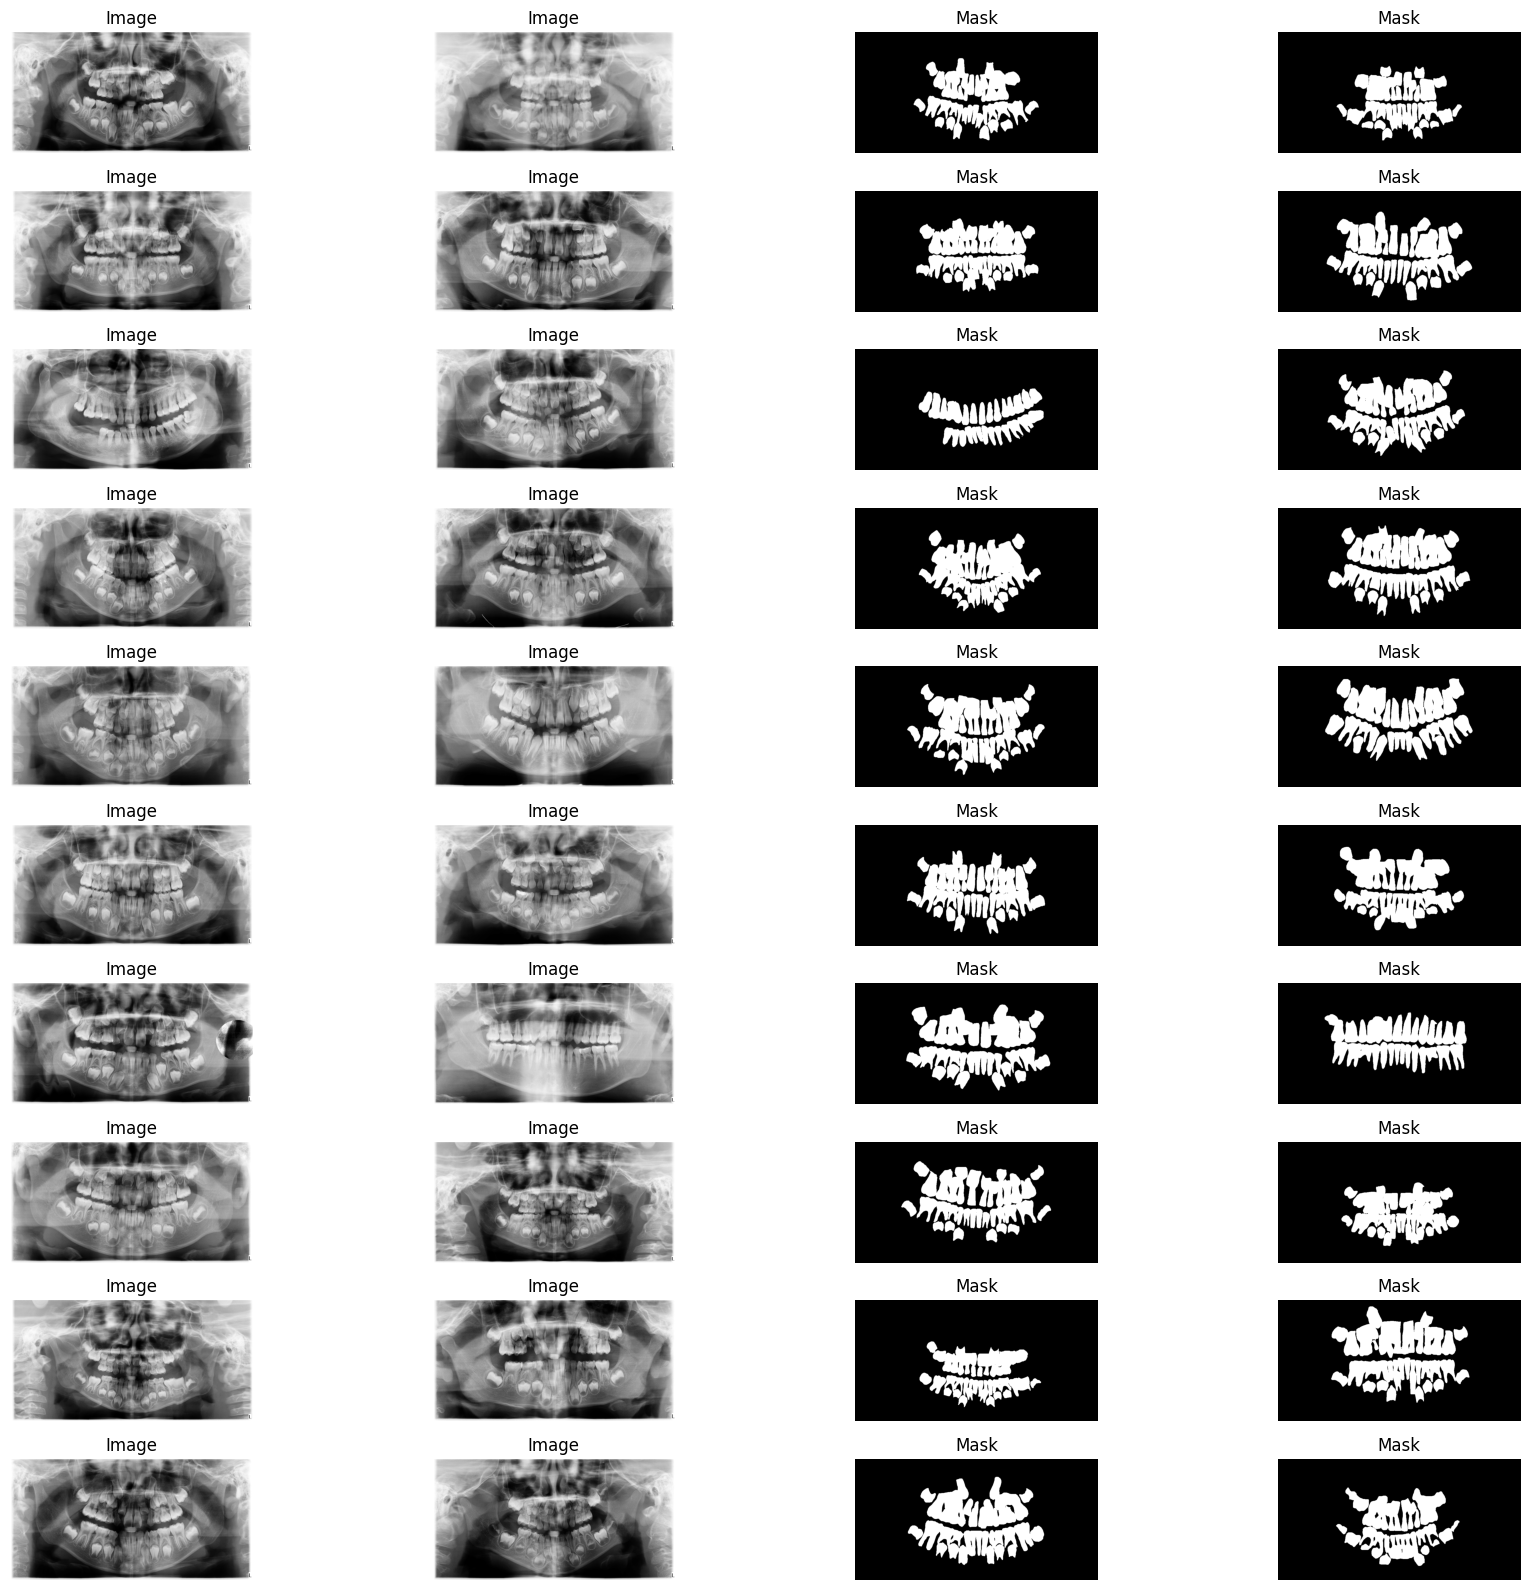

time: 2.42 s (started: 2024-12-05 14:46:23 +00:00)


In [8]:
plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(20 // 2, 4, width_ratios=[1, 1, 1, 1])
for i in range(20):
    ax0 = plt.subplot(gs[i // 2, i % 2])
    ax1 = plt.subplot(gs[i // 2, i % 2 + 2])
    ax0.imshow(validImages[i], cmap='gray', aspect='auto')
    ax1.imshow(validMasks[i], cmap='gray', aspect='auto')
    ax0.set_title('Image')
    ax1.set_title('Mask')
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
plt.tight_layout()
plt.show()

# Define Dice Loss

In [10]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def bfce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def binaryIoU_loss(y_true, y_pred):
    IoU =  tf.keras.metrics.BinaryIoU()(y_true, y_pred)
    return 1 - IoU

time: 947 µs (started: 2024-12-05 15:04:10 +00:00)


# Proposing a generative neural network architecture

In [11]:
def convolution(input, filter, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn1')(x)
    
    if conv_type == 'decoder':
        x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
        x = layers.Conv2D(filter*2, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.GroupNormalization(groups=filter*2, name=f'{name_prefix}_gn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
        x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv3')(x)
        x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn3')(x)
    
    x = layers.average([x, layers.Conv2D(filter, kernel_size=1, padding='same', strides=1, kernel_initializer=initializer, name=f'{name_prefix}_conv4')(input)], name=f'{name_prefix}_residual_connection')
    x = layers.Activation(activation, name=f'{name_prefix}_rescon_activation')(x)
    return x

time: 937 µs (started: 2024-12-05 15:04:10 +00:00)


In [12]:
def encoder(input, filter, padding, strides, kernel, activation, name_prefix):
    x = input
    x = convolution(x, filter, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    downsample = layers.AveragePooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return downsample, x

time: 590 µs (started: 2024-12-05 15:04:10 +00:00)


In [13]:
def decoder(input, filter, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filter, padding = padding, kernel_size = kernel,
                               activation=activation, strides = 2, kernel_initializer=initializer,
                               use_bias=False, name=f'{name_prefix}_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    x = layers.average([x, skip], name=f'{name_prefix}_skip_connection')
    x = convolution(x, filter, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 532 µs (started: 2024-12-05 15:04:10 +00:00)


In [14]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 1.33 ms (started: 2024-12-05 15:04:10 +00:00)


In [15]:
def generator(input, filter, padding, strides, kernel, model_weights=None, weights_path=''):
    x = input
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder5')
    deco1 = decoder(con5, filter*16, skip5, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder1')
    deco2 = decoder(deco1, filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder2')
    deco3 = decoder(deco2, filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder3')
    deco4 = decoder(deco3, filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder4')
    deco5 = decoder(deco4, filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder5')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(1, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='sigmoid', 
                                    name='generator_output_layer')(deco5)
    
    generator = models.Model(inputs=input, outputs=output, name='generator')
    
    if model_weights and weights_path:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 979 µs (started: 2024-12-05 15:04:10 +00:00)


In [16]:
generator = generator(input=layers.Input(shape = IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                            model_weights=None, 
                            weights_path="")

2024-12-05 15:04:10.269788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 15:04:10.270010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-05 15:04:10.270107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 512, 1024, 32)        288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 512, 1024, 32)        64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 512, 1024, 32)        64        ['input_1[0][0]']     

In [17]:
# tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names=True, to_file='./chart/generator.png')

time: 166 µs (started: 2024-12-05 15:04:11 +00:00)


In [18]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay, model_weights, weights_path=''):
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder5')
    x = layers.GlobalAveragePooling2D()(con5)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs=[maskInput, ImageInput], outputs=x, name='discriminator')
    if model_weights is not None:
        discriminator.load_weights(weights_path)
    discriminator.compile(loss=lossFn, loss_weights=[1],
                          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay),)
    discriminator.summary()
    return discriminator

time: 851 µs (started: 2024-12-05 15:04:11 +00:00)


In [19]:
discriminator = discriminator(ImageInput=layers.Input(shape=IMAGE_SHAPE), 
                                    maskInput=layers.Input(shape=MASK_SHAPE),
                                    filter=32, padding = 'same', strides=1, kernel=3, 
                                    lossFn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    learning_rate=ETA, weight_decay=WEIGHT_DECAY,
                                    model_weights=None,
                                    weights_path="")

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 multiply (Multiply)         (None, 512, 1024, 1)         0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 disc_encoder1_conv1 (Conv2  (None, 512, 1024, 32)        288       ['multiply[0][0]']

In [20]:
# tf.keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names=True, to_file='./chart/discriminator.png')

time: 155 µs (started: 2024-12-05 15:04:11 +00:00)


In [21]:
def GAN(discriminator, generator, learning_rate, weight_decay, lossFn):
    imageInput=layers.Input(shape=IMAGE_SHAPE, name="image_Input")
    maskInput=layers.Input(shape=MASK_SHAPE, name="mask_Input")
    
    discriminator.trainable = False
    
    fakeMasks = generator(imageInput)
    discriminatorInput = discriminator([fakeMasks, imageInput])
    
    gan = models.Model(inputs=[maskInput, imageInput],
                       outputs=[discriminatorInput, fakeMasks],
                       name='cgan')
    
    gan.compile(loss=lossFn, loss_weights=[1,100], 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate*0.5, weight_decay=weight_decay*0.5))
    gan.summary()
    return gan

time: 1.07 ms (started: 2024-12-05 15:04:11 +00:00)


In [22]:
gan = GAN(discriminator=discriminator, generator=generator,
          learning_rate=ETA, weight_decay=WEIGHT_DECAY, 
          lossFn=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 'mae'])

# Notes the loss functions is (log BCE + MAE * 100(lambda))
# Following the isola et al loss functions 

Model: "cgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_Input (InputLayer)    [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 generator (Functional)      (None, 512, 1024, 1)         2174179   ['image_Input[0][0]']         
                                                          3                                       
                                                                                                  
 mask_Input (InputLayer)     [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    1744609   ['generator[0][0]',        

In [23]:
# tf.keras.utils.plot_model(gan, show_shapes = True, show_layer_names=True, to_file='./chart/gan.png')

time: 161 µs (started: 2024-12-05 15:04:12 +00:00)


In [24]:
def samples(generator, images, realMasks):
    predMasks = generator.predict(images, verbose=0)
    plt.figure(figsize=(12,6))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title('Input Image')
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title('Ground Truth')
        plt.imshow(realMasks[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(predMasks[i], cmap='gray')
        plt.axis('off')
    plt.show()

def samples_animated(generator, images, realMasks, output_folder='./animation', filename="sample_pair.png"):
    predMasks = generator.predict(images, verbose=0)
    plt.figure(figsize=(12, 6))

    # Plot input image
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(images[1], cmap='gray')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    plt.imshow(predMasks[1], cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(realMasks[1], cmap='gray')
    plt.axis('off')

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, filename)
    plt.show()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)

time: 916 µs (started: 2024-12-05 15:04:12 +00:00)


2024-12-05 15:04:15.720247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-05 15:04:48.466522: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc318c7a790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-05 15:04:48.466702: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-05 15:04:48.470733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733411088.526009    8821 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-05 15:05:48.514676: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.77GiB with freed_by_count=0. The caller indicates that th

Epoch/Epochs: 0/2000
discriminator loss: [tag: 0.6898545622825623], generator loss: [tag: [51.2208251953125, 0.7188307046890259, 0.5050199627876282]]


2024-12-05 15:06:52.655829: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-05 15:06:52.723813: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-05 15:06:52.723880: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-05 15:06:52.874537: W external/local_tsl/tsl/framework/bfc_

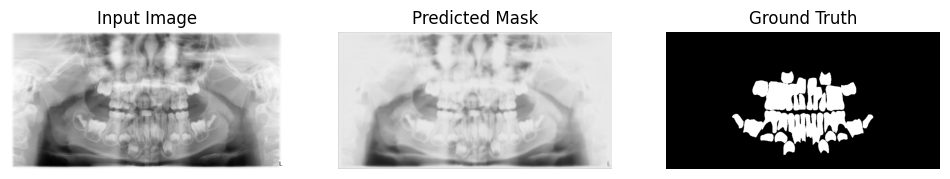

Epoch/Epochs: 10/2000
discriminator loss: [tag: 0.45918434858322144], generator loss: [tag: [43.615692138671875, 1.317304015159607, 0.42298388481140137]]


<Figure size 640x480 with 0 Axes>

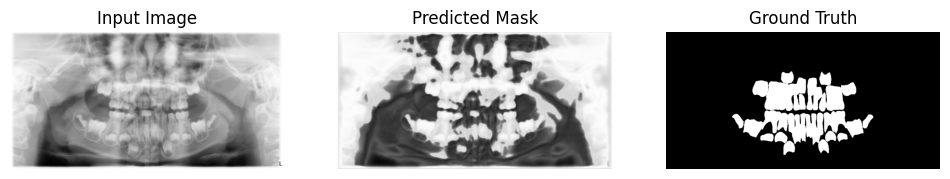

Epoch/Epochs: 20/2000
discriminator loss: [tag: 0.1451800912618637], generator loss: [tag: [36.73008346557617, 2.2636961936950684, 0.3446638882160187]]


<Figure size 640x480 with 0 Axes>

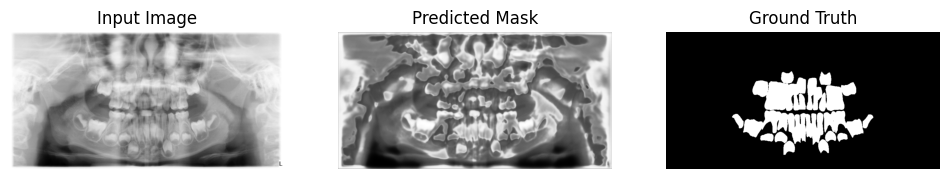

Epoch/Epochs: 30/2000
discriminator loss: [tag: 1.0355466604232788], generator loss: [tag: [33.60990905761719, 1.8912006616592407, 0.31718710064888]]


<Figure size 640x480 with 0 Axes>

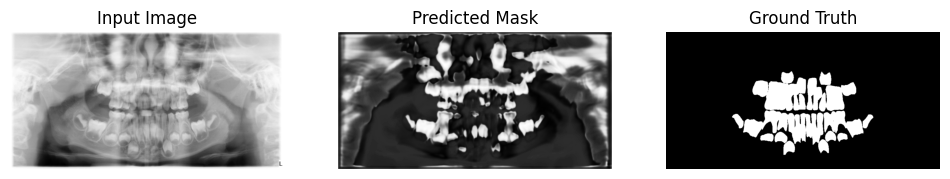

Epoch/Epochs: 40/2000
discriminator loss: [tag: 0.13256584107875824], generator loss: [tag: [28.342966079711914, 3.9137282371520996, 0.24429237842559814]]


<Figure size 640x480 with 0 Axes>

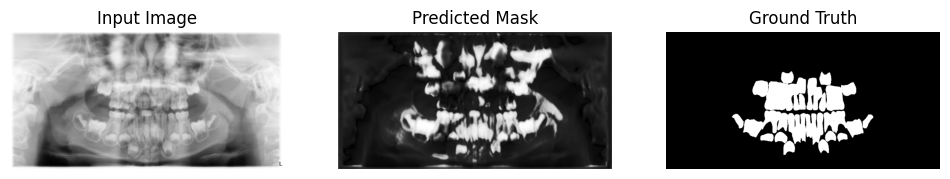

Epoch/Epochs: 50/2000
discriminator loss: [tag: 0.16615383327007294], generator loss: [tag: [20.405006408691406, 1.3336091041564941, 0.19071397185325623]]


<Figure size 640x480 with 0 Axes>

In [ ]:
import gc

tf.keras.backend.clear_session()
gc.collect()

dlossTagList = []
glossTagList = []

for epoch in range(EPOCHS):
    indexs = np.random.randint(0, len(trainImages), size = (BATCH, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (BATCH, ))
    
    fakeMasks = generator.predict([realImages], verbose=0)  
    fakeTag = tf.zeros(shape = (BATCH, ))
    
    allTags = np.hstack([realTag, fakeTag])
    allMasks = np.vstack([realMasks, fakeMasks])
    allImages = np.vstack([realImages, realImages])
    
    dlossTag = discriminator.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realMasks, realImages], [realTag, realMasks])
    
    dlossTagList.append(dlossTag)
    glossTagList.append(glossTag) 
    if epoch % 10 == 0 or epoch == EPOCHS:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {dlossTag}], generator loss: [tag: {glossTag}]")
        # validIndexs = np.random.randint(0, len(validImages), size = (3, ))
        # samples(generator, validImages[:3], validMasks[:3])
        samples_animated(generator, validImages, validMasks, filename=f'{EPOCHS}_samples.png')

min mae index-: 1947
min mae: -0.1548
last mae: 0.9104


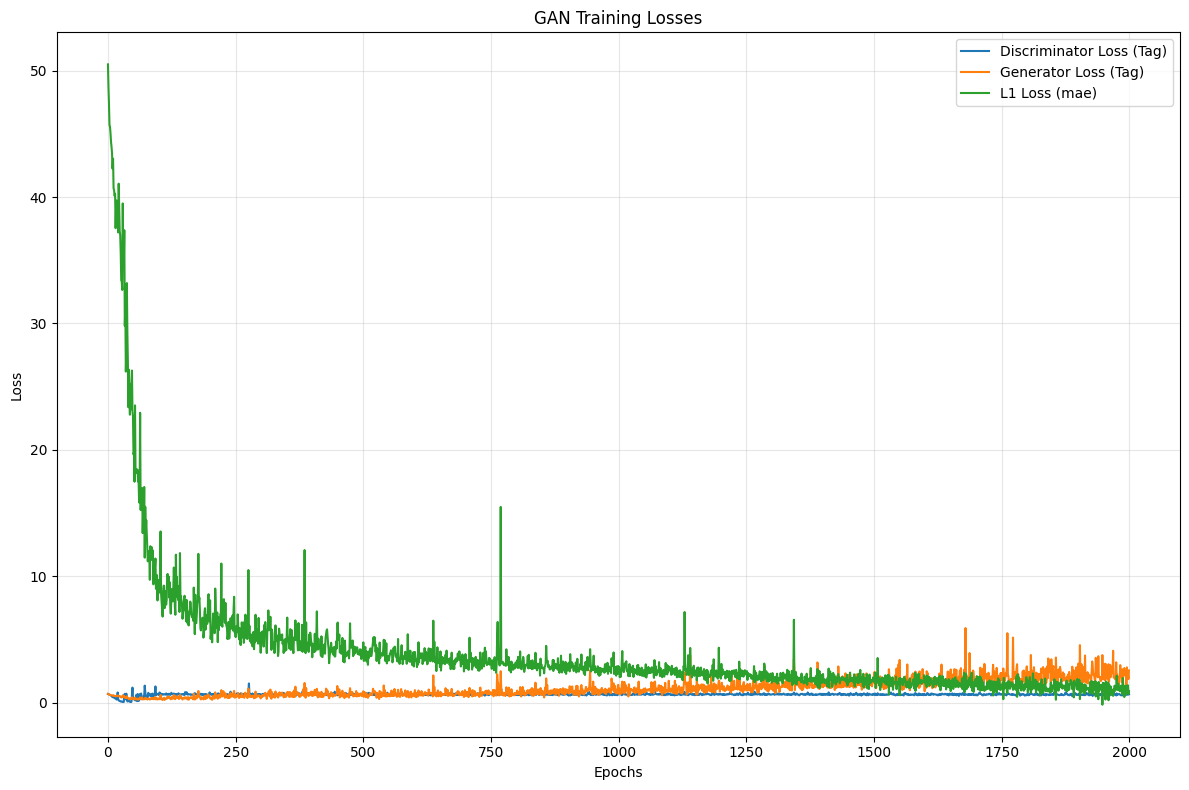

time: 690 ms (started: 2024-12-02 14:29:50 +00:00)


In [32]:
df = pd.DataFrame(glossTagList, columns=["loss 1", "loss 2", "loss 3", "loss 4", "loss 5"])
df['loss 1'] = df['loss 1'] - df['loss 5']
print(f"min mae index-: {df['loss 1'].idxmin()}")
print(f"min mae: {round(np.min(df['loss 1']),4)}")
print(f"last mae: {round(df['loss 1'].iloc[-1],4)}")

plt.figure(figsize=(12, 8))
plt.plot(dlossTagList, label='Discriminator Loss', color='blue')
plt.plot(df['loss 5'], label='Generator Loss (log BCE)', color='orange')
plt.plot(df['loss 1'], label='L1 Loss (MAE)',  color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plot_path, 'first_training_loss_1.png'), dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(dlossTagList, label='Discriminator Loss', color='blue')
plt.plot(df['loss 5'], label='Generator Loss (log BCE)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plot_path, 'first_training_loss_2.png'), dpi=300)
plt.show()

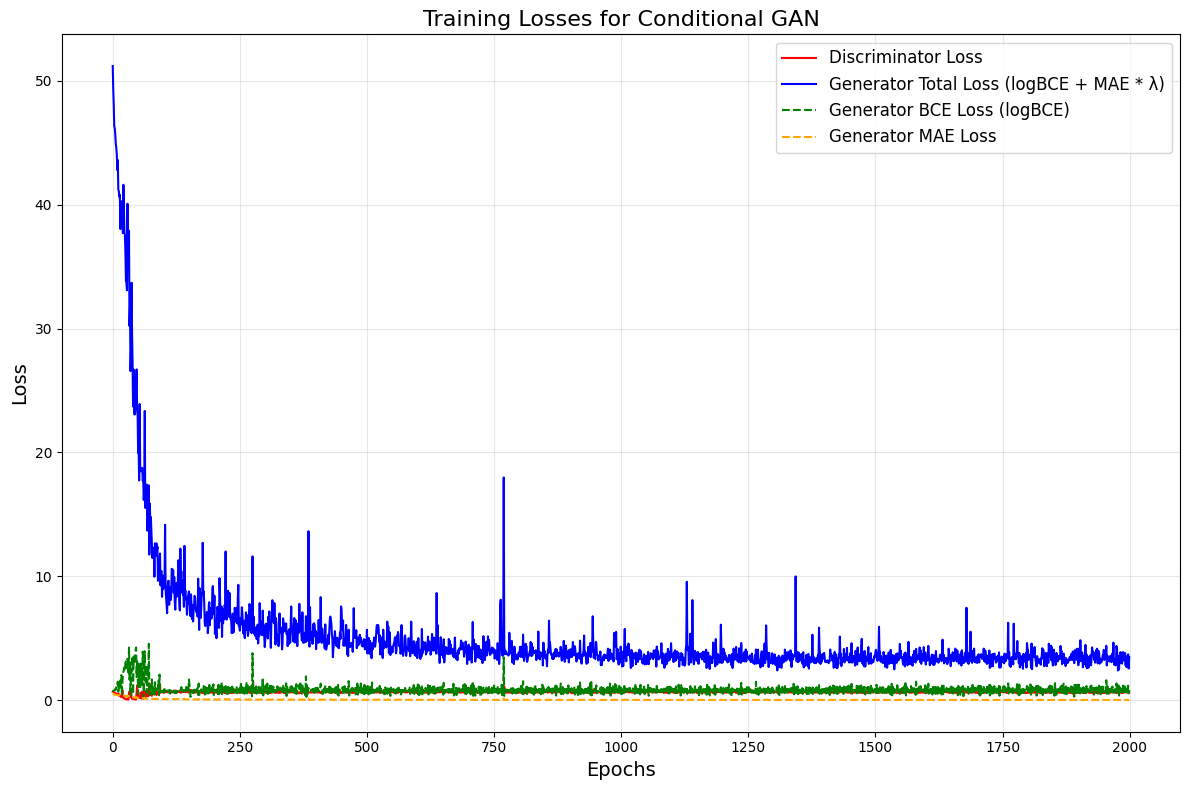

time: 1.03 s (started: 2024-12-02 14:29:50 +00:00)


In [33]:
# Extract specific losses from glossTagList
epochs = np.arange(len(dlossTagList))

# Discriminator loss
discriminator_loss = [dloss for dloss in dlossTagList]

# Generator losses
generator_total_loss = [gloss[0] for gloss in glossTagList]  # Total generator loss
generator_bce_loss = [gloss[4] for gloss in glossTagList]   # BCE loss
generator_mae_loss = [gloss[2] for gloss in glossTagList]   # MAE loss

# Plotting
plt.figure(figsize=(12, 8))

# Plot Discriminator loss
plt.plot(epochs, discriminator_loss, label="Discriminator Loss", color='red', linewidth=1.5)

# Plot Generator total loss
plt.plot(epochs, generator_total_loss, label="Generator Total Loss (logBCE + MAE * λ)", color='blue', linewidth=1.5)

# Plot Generator BCE loss
plt.plot(epochs, generator_bce_loss, label="Generator BCE Loss (logBCE)", color='green', linestyle='--', linewidth=1.5)

# Plot Generator MAE loss
plt.plot(epochs, generator_mae_loss, label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)
# Customize plot
plt.title("Training Losses for Conditional GAN", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_3.png'), dpi=300)
plt.show()


Discriminator Loss: Mean = 0.6646, Std = 0.0477
Generator Total Loss: Mean = 3.6793, Std = 0.7968
Generator BCE Loss: Mean = 0.8154, Std = 0.2364
Generator MAE Loss: Mean = 0.0286, Std = 0.0073


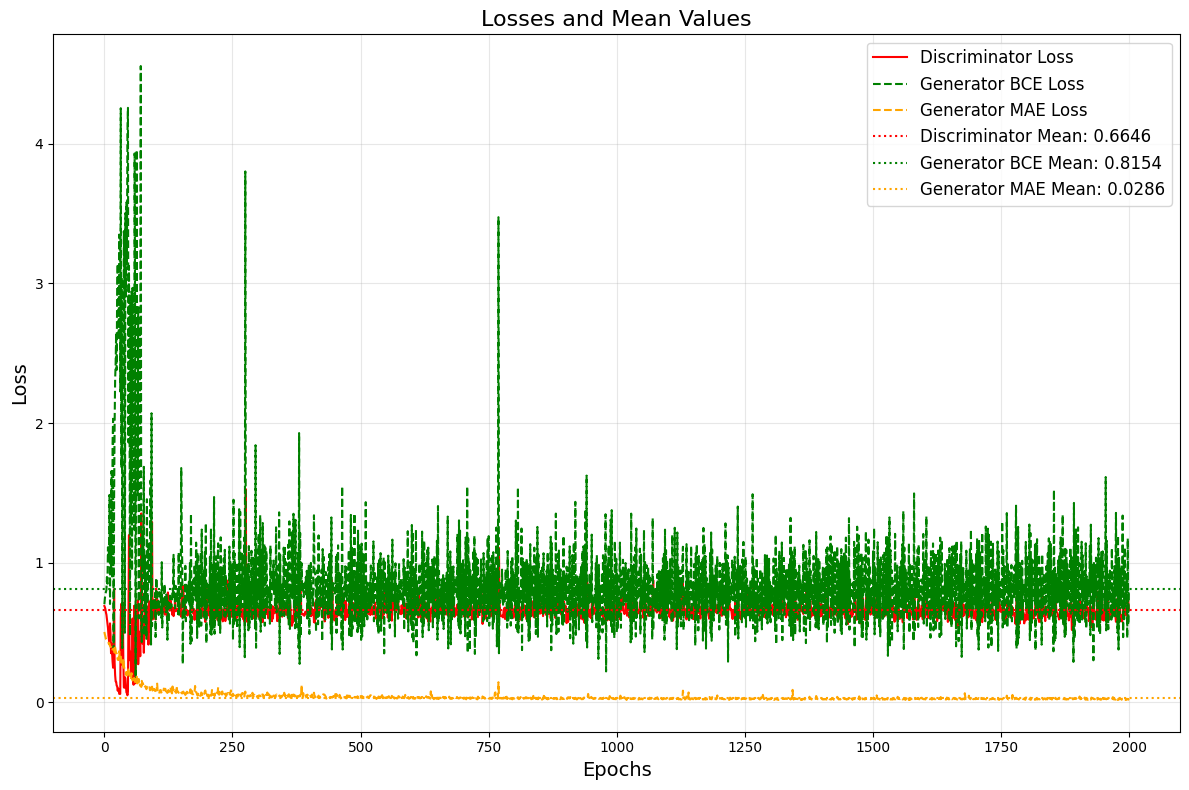

time: 769 ms (started: 2024-12-02 14:29:52 +00:00)


In [34]:
# Define stable range (e.g., from epoch 500 onward)
stable_start = 500
stable_end = len(epochs)

# Extract stable region losses
stable_dloss = dlossTagList[stable_start:stable_end]
stable_gloss = glossTagList[stable_start:stable_end]

# Generator losses
stable_total_loss = [gloss[0] for gloss in stable_gloss]
stable_bce_loss = [gloss[1] for gloss in stable_gloss]
stable_mae_loss = [gloss[2] for gloss in stable_gloss]

# Calculate mean and standard deviation
dloss_mean, dloss_std = np.mean(stable_dloss), np.std(stable_dloss)
total_mean, total_std = np.mean(stable_total_loss), np.std(stable_total_loss)
bce_mean, bce_std = np.mean(stable_bce_loss), np.std(stable_bce_loss)
mae_mean, mae_std = np.mean(stable_mae_loss), np.std(stable_mae_loss)

# Print results
print(f"Discriminator Loss: Mean = {dloss_mean:.4f}, Std = {dloss_std:.4f}")
print(f"Generator Total Loss: Mean = {total_mean:.4f}, Std = {total_std:.4f}")
print(f"Generator BCE Loss: Mean = {bce_mean:.4f}, Std = {bce_std:.4f}")
print(f"Generator MAE Loss: Mean = {mae_mean:.4f}, Std = {mae_std:.4f}")

# Optional: Add horizontal lines to the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot losses
plt.plot(epochs, dlossTagList, label="Discriminator Loss", color='red', linewidth=1.5)
plt.plot(epochs, [gloss[1] for gloss in glossTagList], label="Generator BCE Loss", color='green', linestyle='--', linewidth=1.5)
plt.plot(epochs, [gloss[2] for gloss in glossTagList], label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)

# Add horizontal lines for means
plt.axhline(dloss_mean, color='red', linestyle=':', label=f"Discriminator Mean: {dloss_mean:.4f}")
plt.axhline(bce_mean, color='green', linestyle=':', label=f"Generator BCE Mean: {bce_mean:.4f}")
plt.axhline(mae_mean, color='orange', linestyle=':', label=f"Generator MAE Mean: {mae_mean:.4f}")

# Customize plot
plt.title("Losses and Mean Values", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_4.png'), dpi=300)
plt.show()

In [24]:
generator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_generator.h5'
discriminator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_discriminator.h5'

generator_path = os.path.join(model_path, generator_saved)
discriminator_path = os.path.join(model_path, discriminator_saved)

generator.save_weights(generator_path)
discriminator.save_weights(discriminator_path)

# - Now we will train the generator again with a number of layers frozen in order to maintain the capacity that the generator has gained.

time: 374 µs (started: 2024-12-03 04:51:50 +00:00)


In [25]:
weight_path = generator_path

generator2 = generator(input=layers.Input(shape=IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                             model_weights=True, weights_path=weight_path)

for layer in generator2.layers[:20]:
    layer.trainable = False
    
optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-7)
generator2.compile(loss=bce_dice_loss,
                         optimizer=optimizer, 
                         metrics=[tf.keras.metrics.Precision(name = 'precision'),
                                  tf.keras.metrics.Recall(name = 'recall'), 
                                  tf.keras.metrics.BinaryIoU(name = 'IoU'),
                                  dice_score,
                                  tf.keras.metrics.BinaryCrossentropy(name='logBCE', from_logits=True),
                                  tf.keras.metrics.MeanAbsoluteError(name='MAE')])

2024-12-03 04:51:50.514807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 04:51:50.515204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 04:51:50.515321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 1024, 1)]       0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 512, 1024, 32)        288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 512, 1024, 32)        64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 512, 1024, 32)        64        ['input_1[0][0]']     

# Evaluate the generator model

In [26]:
generator2.evaluate(validImages, validMasks, batch_size=BATCH)

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-12-03 04:52:22.931757: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


5/5 [==============================] - 48s 224ms/step - loss: 2.3846 - precision: 0.9290 - recall: 0.9252 - IoU: 0.9171 - dice_score: 0.9271 - logBCE: 2.3117 - MAE: 0.0251


[2.3846054077148438,
 0.9289746284484863,
 0.9251869916915894,
 0.9170737266540527,
 0.9271434545516968,
 2.31174898147583,
 0.025141140446066856]

time: 48.6 s (started: 2024-12-03 04:51:52 +00:00)


In [27]:
generator2.evaluate(testImages, testMasks, batch_size=BATCH)

3/3 [==============================] - 9s 4s/step - loss: 3.0136 - precision: 0.9402 - recall: 0.9050 - IoU: 0.9121 - dice_score: 0.9237 - logBCE: 2.9357 - MAE: 0.0266


[3.0136125087738037,
 0.9402103424072266,
 0.9050019383430481,
 0.9120879173278809,
 0.9237003922462463,
 2.9356753826141357,
 0.02659488096833229]

time: 9.54 s (started: 2024-12-03 04:52:41 +00:00)


In [28]:
def draw(images, masks, y_pred):
    plt.figure(figsize = (12, 24))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n], cmap = 'gray')
            plt.title('Image')
            plt.axis('off')
            index = 0
        elif index == 0:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
            plt.title('Original Mask')
            plt.axis('off')
            index = 1
        elif index == 1:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(np.reshape(y_pred[n], IMAGE_SHAPE[:2]), alpha = 0.6, cmap = 'gray')
            plt.title('Predict Mask')
            plt.axis('off')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

time: 820 µs (started: 2024-12-03 04:52:50 +00:00)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


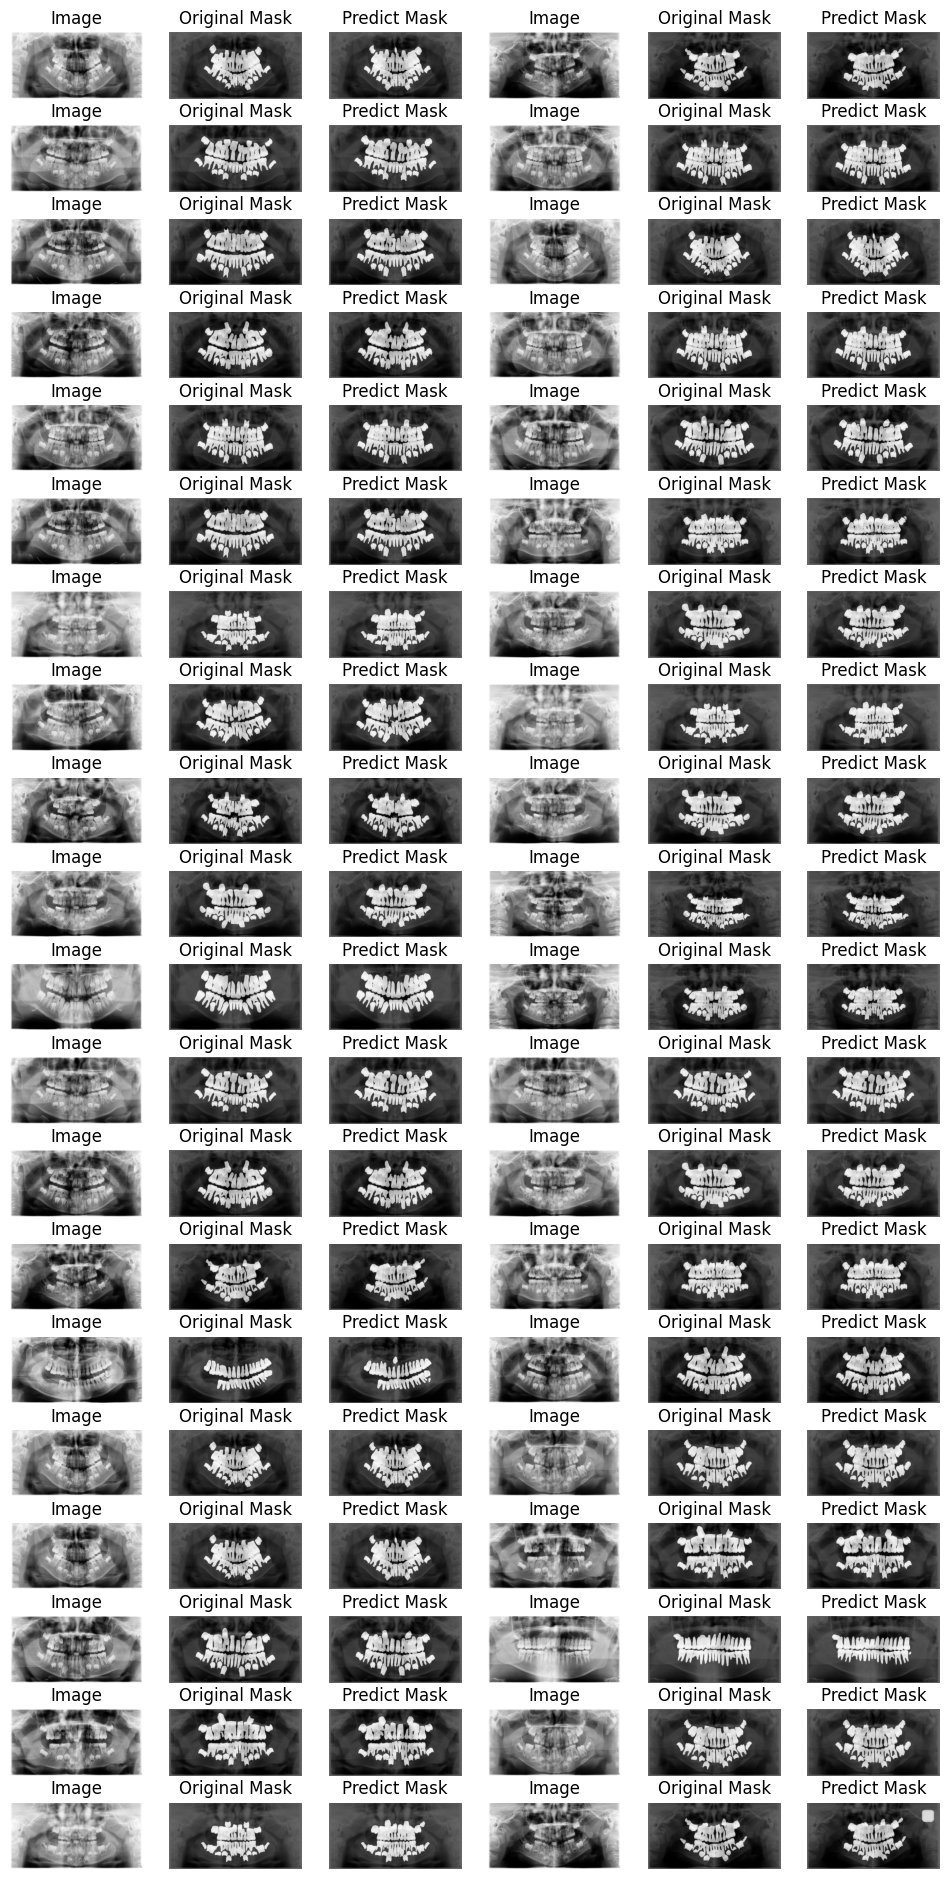

time: 38.1 s (started: 2024-12-03 04:52:50 +00:00)


In [29]:
masks_pred = generator2.predict(validImages, verbose=0, batch_size=BATCH)
masks_pred = (masks_pred >= 0.5).astype('int')
masks_pred.shape
draw(validImages, validMasks, masks_pred)

# Re-training of the generator according to the pixel2pixel methodology

In [30]:
def create_tf_dataset(images, masks, batch_size, is_training=True):
    # Convert numpy arrays to tensors
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images_tensor, masks_tensor))
    
    if is_training:
        # Only shuffle for training dataset
        dataset = dataset.cache().shuffle(buffer_size=len(images))
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Create TensorFlow datasets
train_dataset = create_tf_dataset(trainImages, trainMasks, batch_size=2, is_training=True)
valid_dataset = create_tf_dataset(validImages, validMasks, batch_size=2, is_training=False)
test_dataset = create_tf_dataset(testImages, testMasks, batch_size=2, is_training=False)

time: 13.6 s (started: 2024-12-03 04:53:28 +00:00)


In [31]:
train_samples = len(trainImages)
steps_per_epoch = train_samples // 2

del trainImages
del trainMasks

time: 28.9 ms (started: 2024-12-03 04:53:42 +00:00)


In [32]:
import gc

tf.keras.backend.clear_session()
gc.collect()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,           # Reduce the learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    mode='min',
    min_delta=1e-4,       # minimum changed in monitor metrics
)

history = generator2.fit(train_dataset, 
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=valid_dataset, 
                         verbose=2, 
                         callbacks=[early_stopping, reduce_lr])

Epoch 1/100


2024-12-03 04:54:06.122102: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f779893d560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-03 04:54:06.122160: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-03 04:54:06.147793: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733201646.264860     845 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-03 04:54:07.889892: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-0

407/407 - 175s - loss: 1.0459 - precision: 0.8776 - recall: 0.9198 - IoU: 0.8872 - dice_score: 0.8978 - logBCE: 0.9437 - MAE: 0.0355 - val_loss: 0.2724 - val_precision: 0.8497 - val_recall: 0.9322 - val_IoU: 0.8762 - val_dice_score: 0.8891 - val_logBCE: 0.1615 - val_MAE: 0.0434 - lr: 1.0000e-05 - 175s/epoch - 431ms/step
Epoch 2/100
407/407 - 129s - loss: 0.2886 - precision: 0.8892 - recall: 0.8973 - IoU: 0.8826 - dice_score: 0.8931 - logBCE: 0.1817 - MAE: 0.0427 - val_loss: 0.1920 - val_precision: 0.8901 - val_recall: 0.9263 - val_IoU: 0.8963 - val_dice_score: 0.9079 - val_logBCE: 0.0998 - val_MAE: 0.0423 - lr: 1.0000e-05 - 129s/epoch - 317ms/step
Epoch 3/100
407/407 - 129s - loss: 0.2069 - precision: 0.9057 - recall: 0.8995 - IoU: 0.8923 - dice_score: 0.9021 - logBCE: 0.1090 - MAE: 0.0424 - val_loss: 0.1725 - val_precision: 0.8929 - val_recall: 0.9372 - val_IoU: 0.9032 - val_dice_score: 0.9144 - val_logBCE: 0.0869 - val_MAE: 0.0423 - lr: 1.0000e-05 - 129s/epoch - 317ms/step
Epoch 4/10

# The results obtained

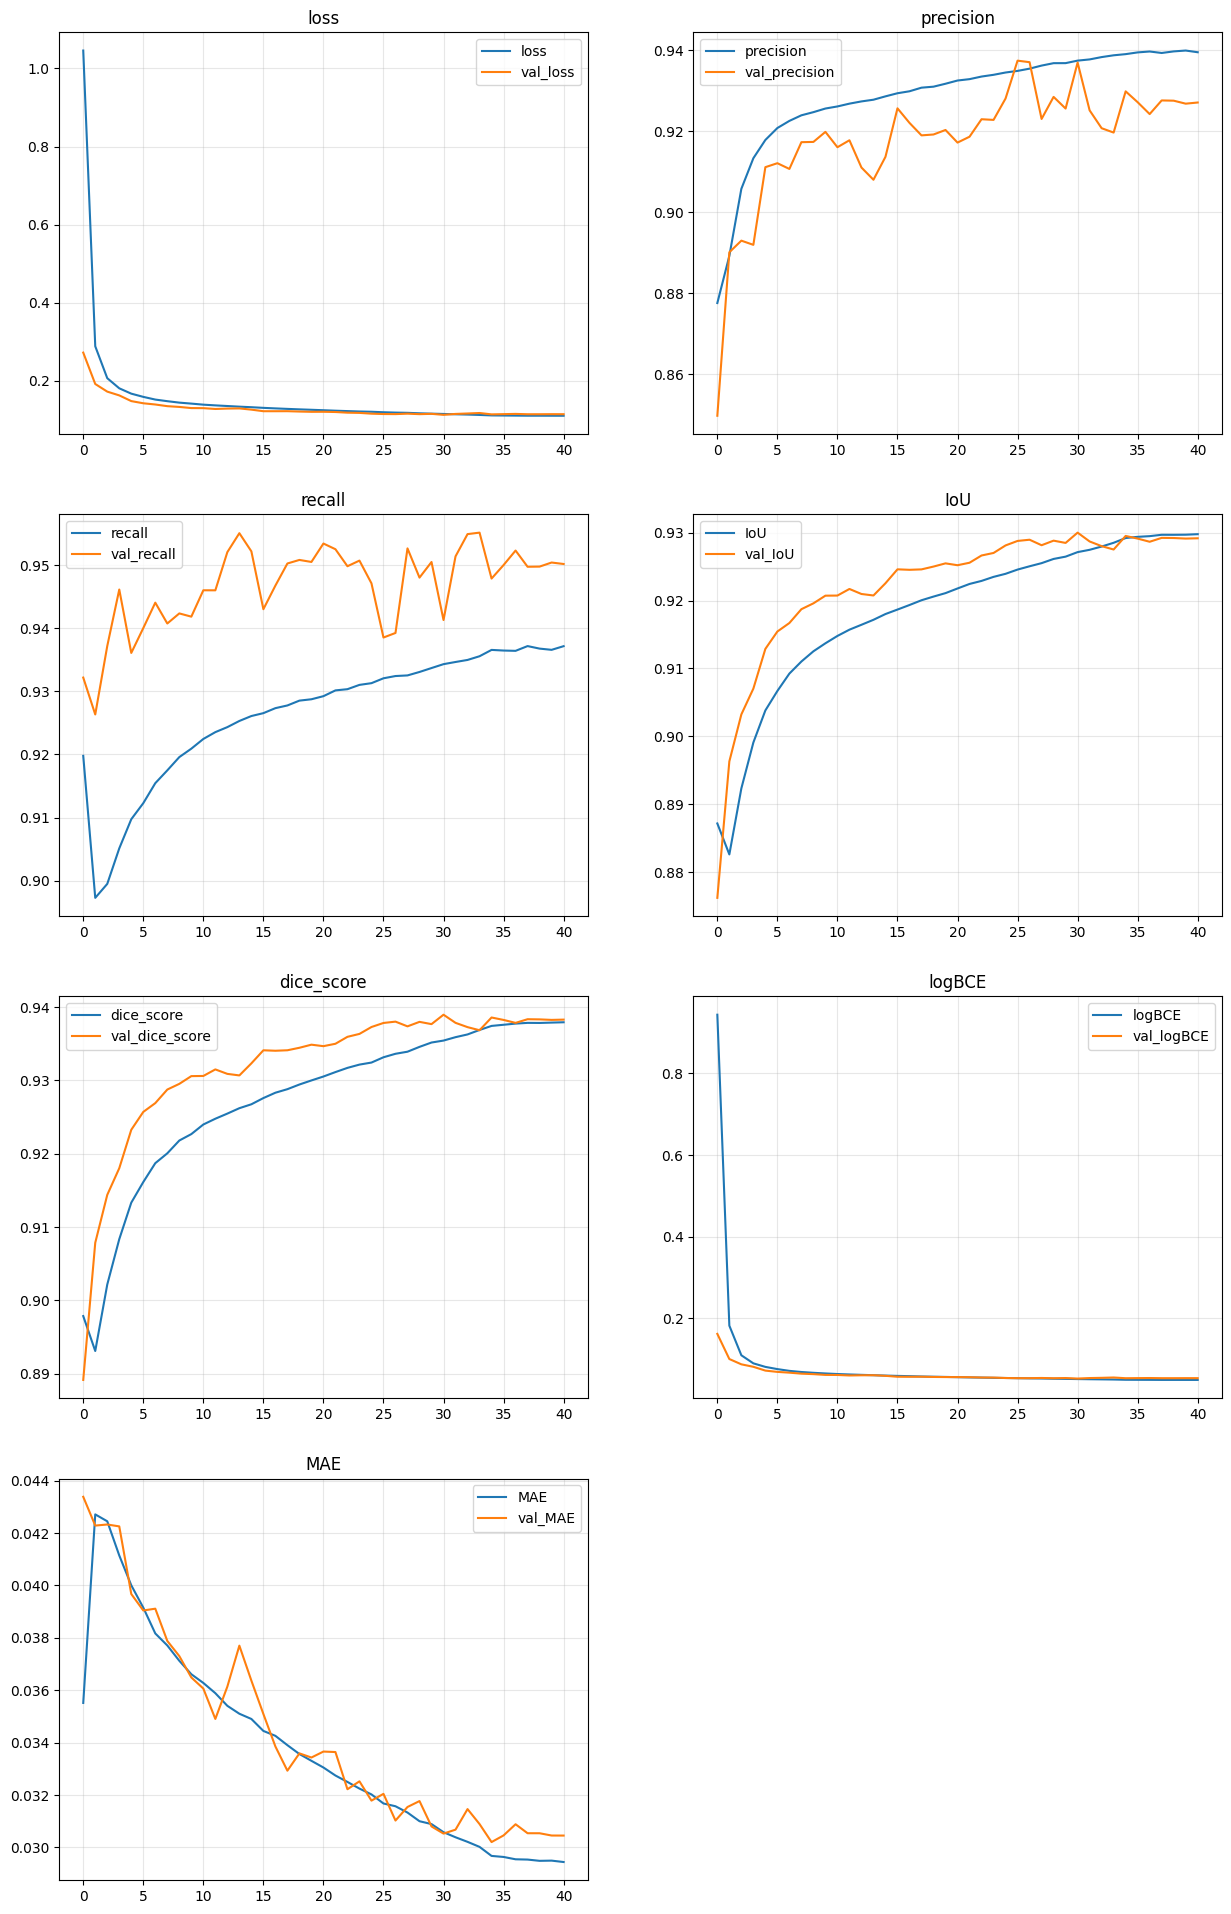

time: 2.32 s (started: 2024-12-03 06:42:39 +00:00)


In [61]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score', 'logBCE', 'MAE']
plt.figure(figsize = (15, 24))
for i in range(7):
    plt.subplot(4, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.grid(alpha=0.3)
    plt.legend()
plt.savefig(os.path.join(plot_path, 'secondtrain_history_chart_1.png'), dpi=300)

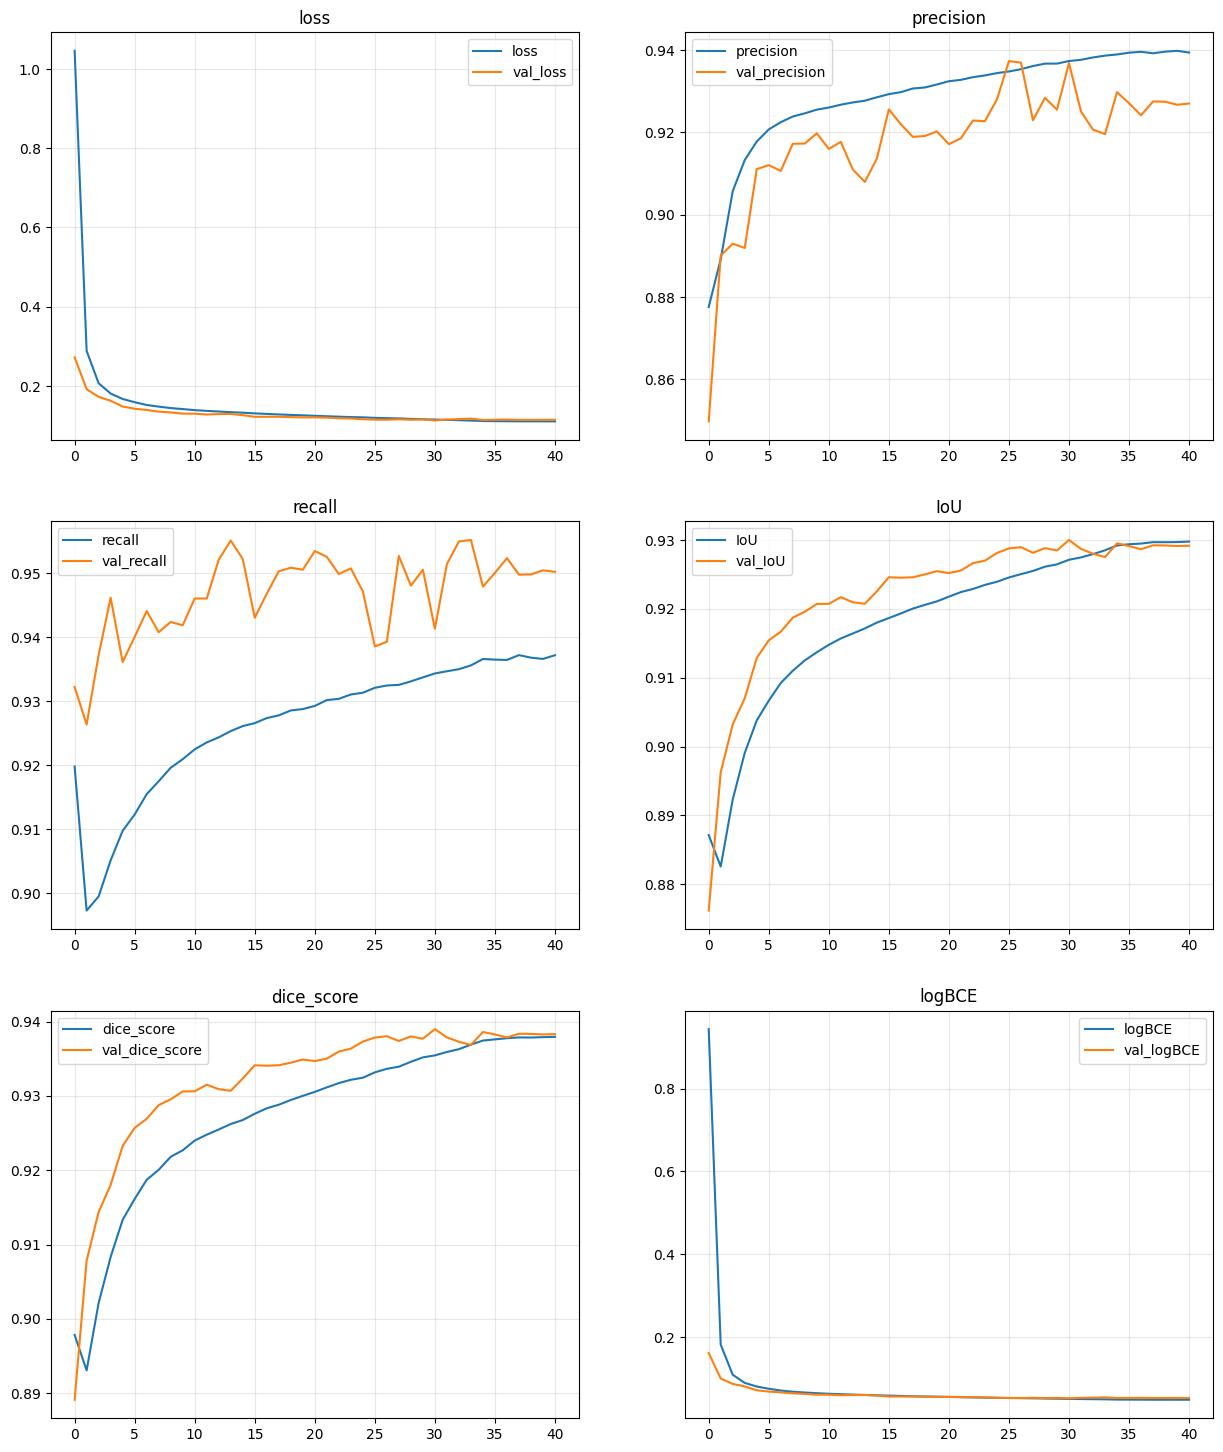

time: 1.85 s (started: 2024-12-03 06:43:18 +00:00)


In [63]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score', 'logBCE', 'MAE']
plt.figure(figsize = (15, 18))
for i in range(6):
    plt.subplot(3, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.grid(alpha=0.3)
    plt.legend()
plt.savefig(os.path.join(plot_path, 'secondtrain_history_chart_2.png'), dpi=300)

In [36]:
generator2.evaluate(valid_dataset)

10/10 [==============================] - 1s 114ms/step - loss: 0.1130 - precision: 0.9369 - recall: 0.9413 - IoU: 0.9300 - dice_score: 0.9390 - logBCE: 0.0520 - MAE: 0.0305


[0.11300774663686752,
 0.9368937611579895,
 0.9413153529167175,
 0.9300051927566528,
 0.9389759302139282,
 0.05198364704847336,
 0.030526086688041687]

time: 1.16 s (started: 2024-12-03 06:31:57 +00:00)


In [38]:
generator2.evaluate(test_dataset)

5/5 [==============================] - 1s 115ms/step - loss: 0.1297 - precision: 0.9434 - recall: 0.9152 - IoU: 0.9193 - dice_score: 0.9295 - logBCE: 0.0591 - MAE: 0.0324


[0.12968701124191284,
 0.9434372782707214,
 0.915189802646637,
 0.9193059206008911,
 0.9294536709785461,
 0.05914062261581421,
 0.03244195878505707]

time: 594 ms (started: 2024-12-03 06:32:19 +00:00)


In [39]:
generator_path2 = os.path.join(model_path, 'final', f'final_{generator_saved}')
generator2.save(generator_path2)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.11/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


time: 305 ms (started: 2024-12-03 06:32:34 +00:00)


In [40]:
generator3 = tf.keras.models.load_model(generator_path2,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

time: 1.48 s (started: 2024-12-03 06:32:35 +00:00)


3/3 [==============================] - 23s 307ms/step
validMasks shape: (10485760,)
predIdxs shape: (10485760,)
              precision    recall  f1-score   support

      Object       0.99      0.99      0.99   8674725
  Background       0.94      0.94      0.94   1811035

    accuracy                           0.98  10485760
   macro avg       0.96      0.96      0.96  10485760
weighted avg       0.98      0.98      0.98  10485760



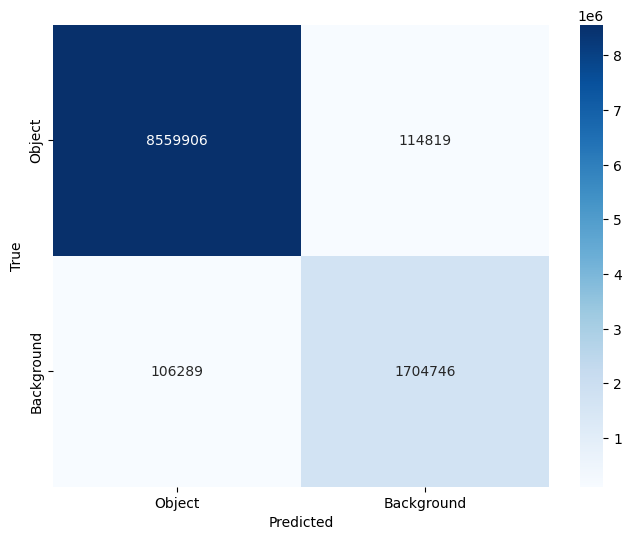

<Figure size 640x480 with 0 Axes>

time: 38.7 s (started: 2024-12-03 06:43:59 +00:00)


In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predIdxs = generator3.predict(validImages, batch_size=8)
predIdxs = (predIdxs >= 0.5).astype('int')

validMasks_flat = validMasks.flatten()
predIdxs_flat = predIdxs.flatten()

print("validMasks shape:", validMasks_flat.shape)
print("predIdxs shape:", predIdxs_flat.shape)

class_names = ["Object", "Background"]

print(classification_report(
    validMasks_flat, predIdxs_flat,
    target_names=class_names
))

conf_mat = confusion_matrix(validMasks_flat, predIdxs_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/notebooks/chart/secondtrain_confusion_matrix.png')

(20, 512, 1024, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


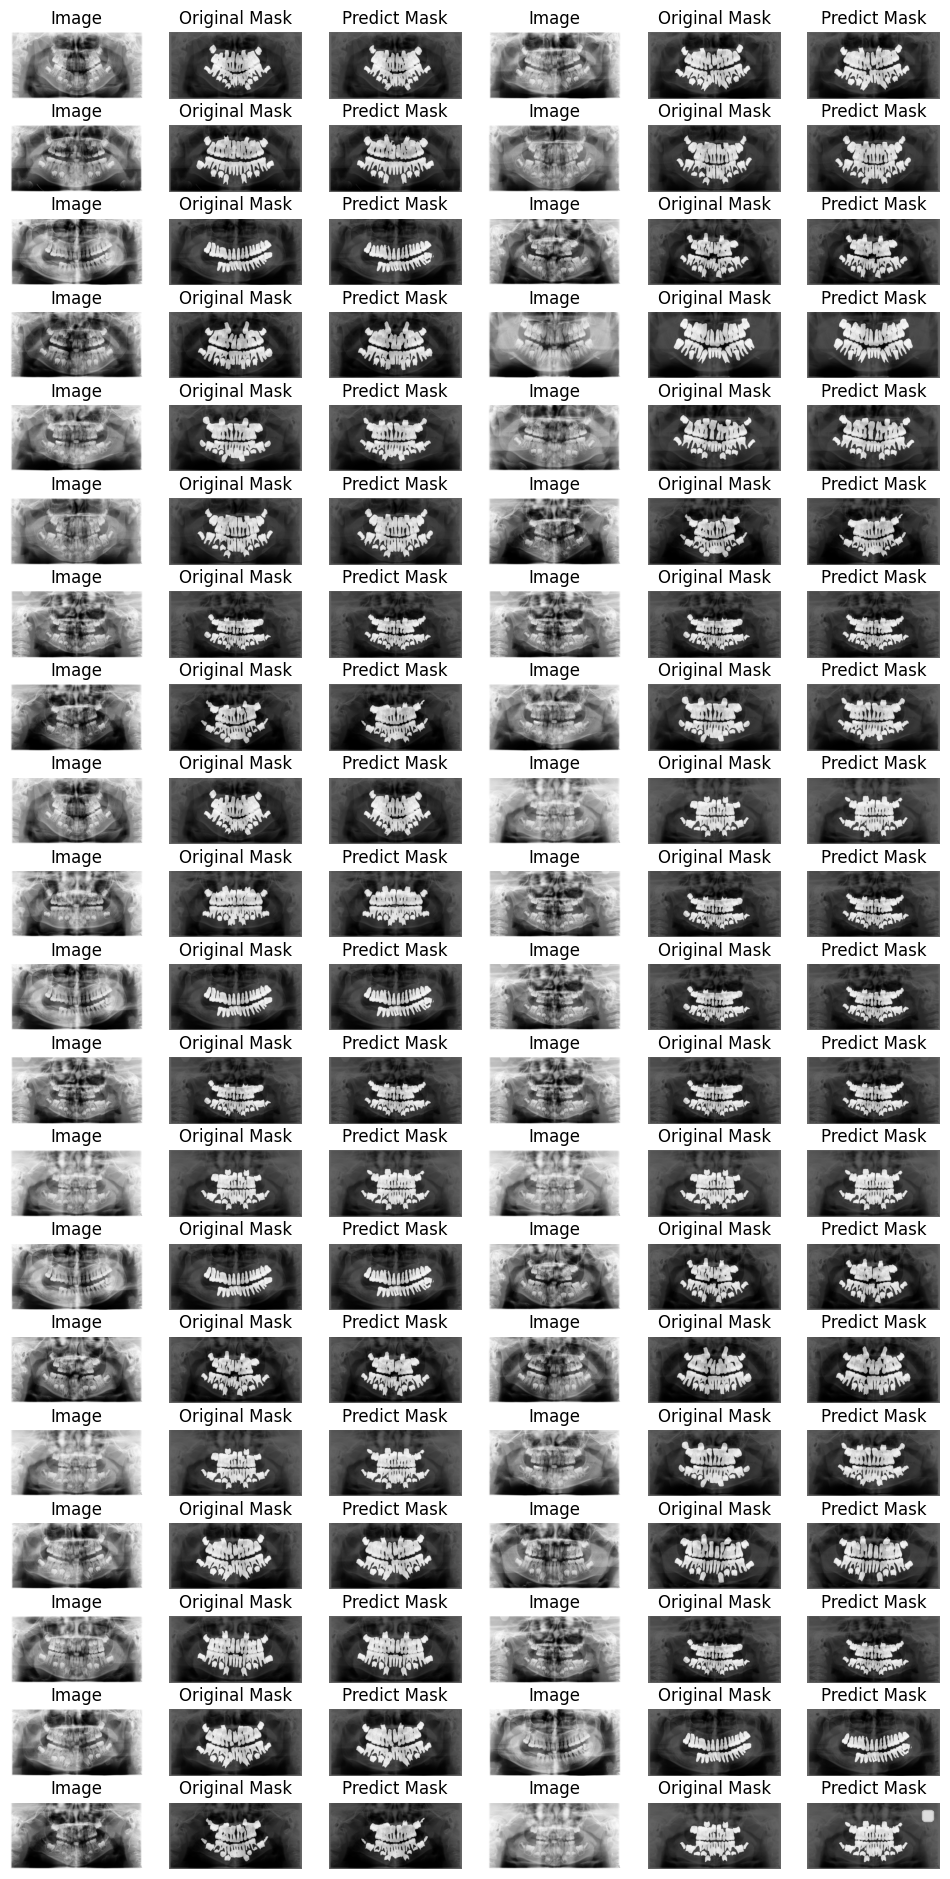

time: 13.2 s (started: 2024-12-03 06:54:41 +00:00)


In [71]:
masksPred = generator3.predict(validImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masksPred.shape)
draw(validImages, validMasks, masksPred)

(815, 512, 1024, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


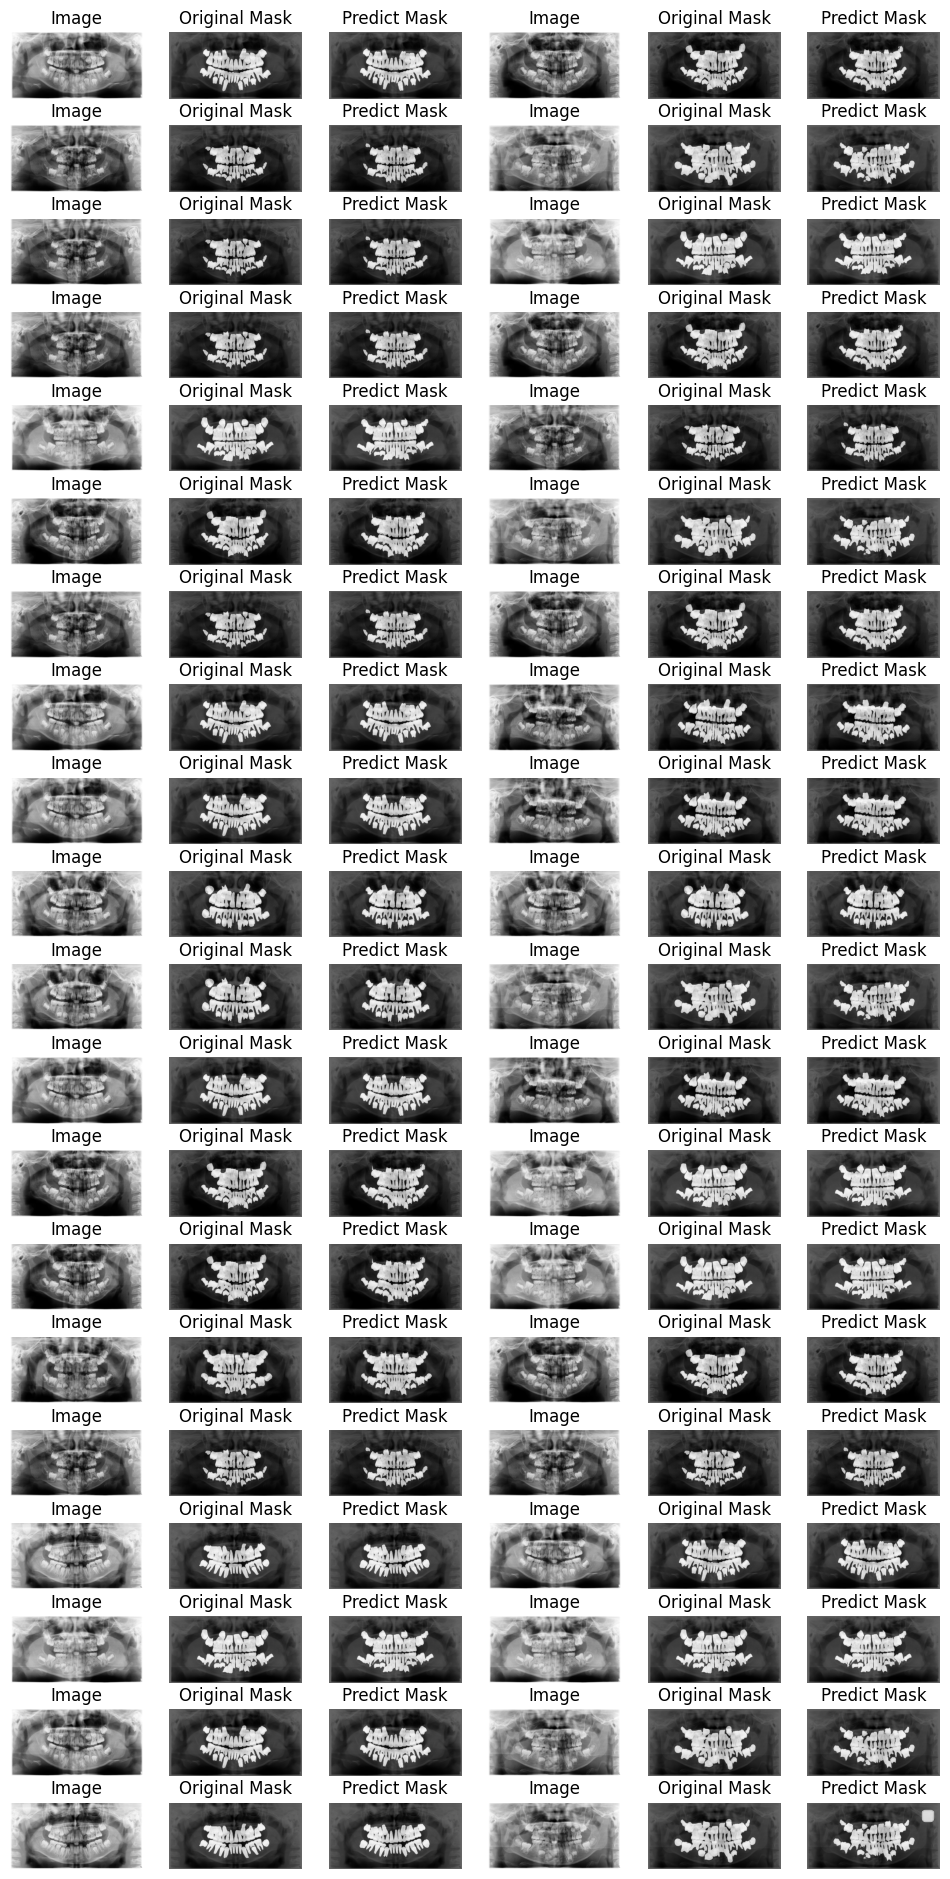

time: 12.3 s (started: 2024-12-03 06:55:08 +00:00)


In [73]:
masksPred = generator3.predict(testImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masks_pred.shape)
draw(testImages, testMasks, masksPred)

(815, 512, 1024, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


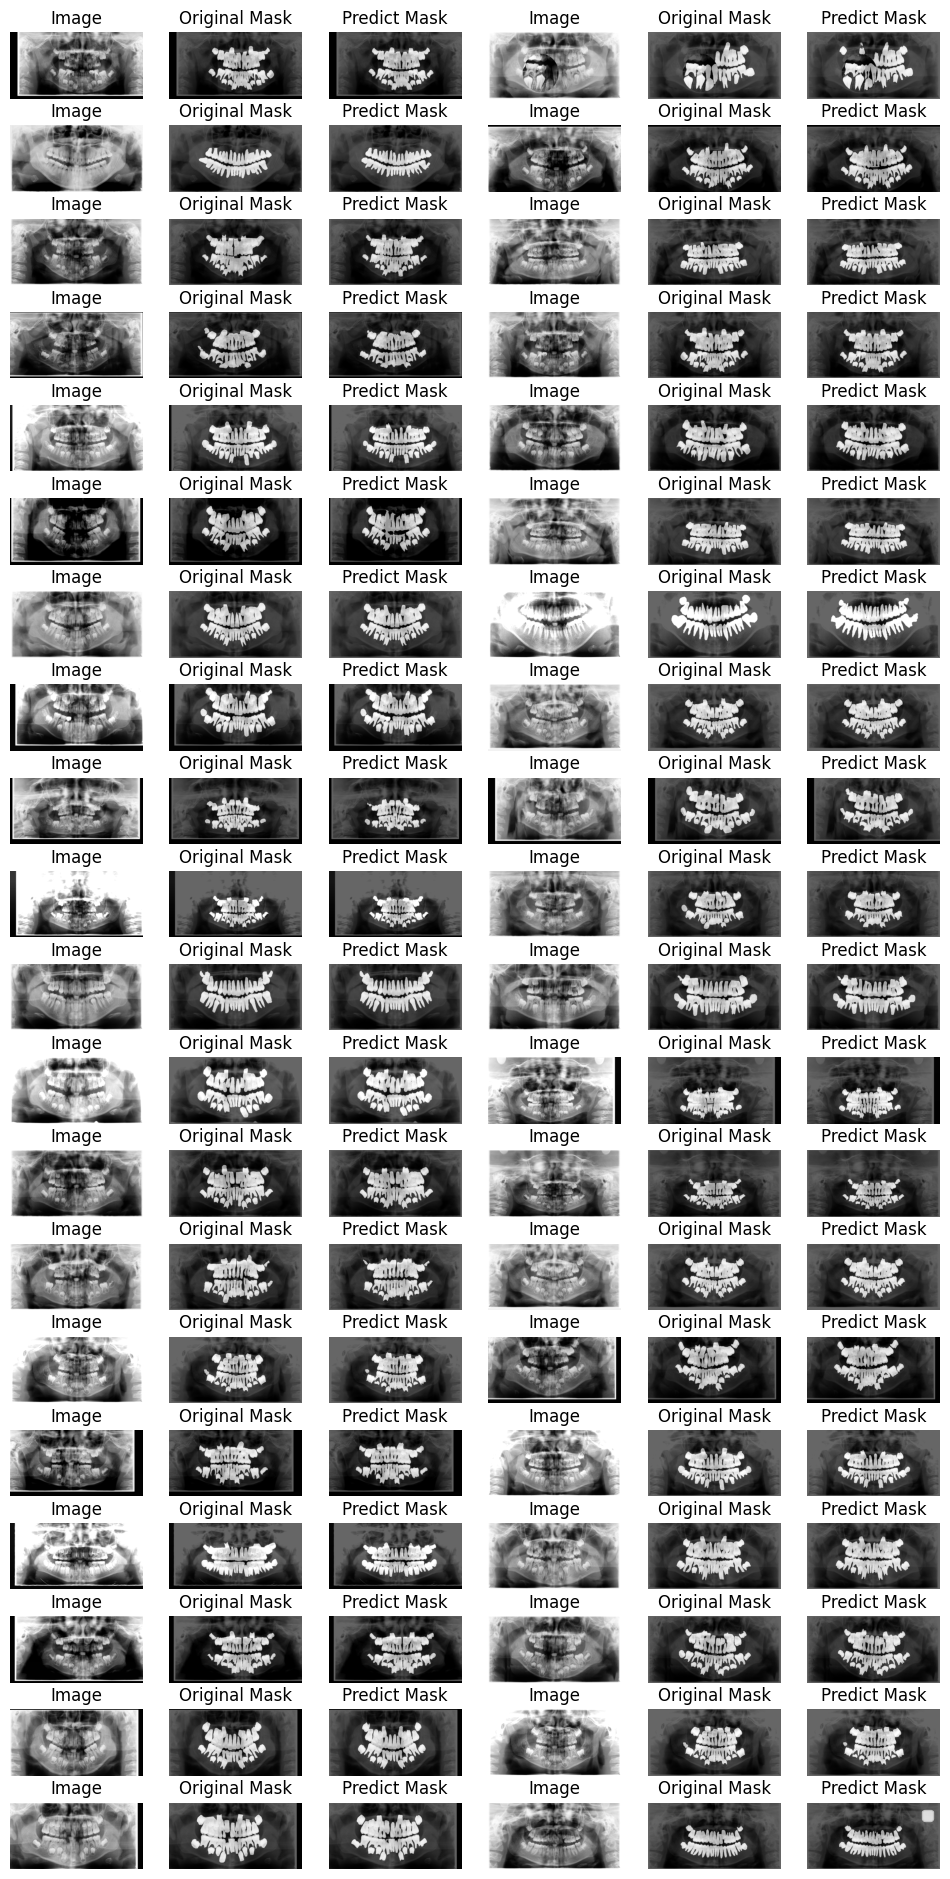

time: 1min 46s (started: 2024-12-03 06:55:21 +00:00)


In [74]:
masksPred = generator3.predict(trainImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masks_pred.shape)
draw(trainImages, trainMasks, masksPred)

In [68]:
import zipfile,os
folder_to_zip = os.path.join(plot_path,'chart')
zip_file_name =  os.path.splitext(generator_saved)[0].replace("_generator", "") + '.zip'
zip_file_name = os.path.join(plot_path, zip_file_name)
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(folder_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)
zipf.close()

print(f"{zip_file_name} success zipping...")

1024_5block_RMSprop_swish+leakyrelu_CGAN_2000_clahe.zip success zipping...
time: 3.44 ms (started: 2024-12-03 06:47:52 +00:00)
